In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/計畫/ntut-project-in-os2d-channel-prune

In [3]:
# !mkdir visualized_image

### Init

In [4]:
# !ls

In [5]:
# !pip install yacs

In [6]:
import torch

def show_gpu_memory_usage():
    """顯示當前 GPU RAM 使用情況"""
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
        device_name = torch.cuda.get_device_name(device)

        # 獲取記憶體使用情況 (轉換為 GB)
        allocated = torch.cuda.memory_allocated(device) / 1024**3
        reserved = torch.cuda.memory_reserved(device) / 1024**3
        total = torch.cuda.get_device_properties(device).total_memory / 1024**3

        print(f"🖥️  GPU 設備: {device_name}")
        print(f"📊 記憶體使用情況:")
        print(f"   已分配: {allocated:.2f} GB")
        print(f"   已保留: {reserved:.2f} GB")
        print(f"   總容量: {total:.2f} GB")
        print(f"   使用率: {(allocated/total)*100:.1f}%")
        print(f"   保留率: {(reserved/total)*100:.1f}%")

        # 視覺化進度條
        usage_percent = int((allocated/total)*100)
        bar_length = 20
        filled_length = int(bar_length * usage_percent / 100)
        bar = '█' * filled_length + '░' * (bar_length - filled_length)
        print(f"   [{bar}] {usage_percent}%")

    else:
        print("❌ CUDA 不可用，無法檢測 GPU 記憶體")

In [7]:
import os
import argparse

import torch
import os
import argparse
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

from os2d.modeling.model import build_os2d_from_config
from os2d.config import cfg
import  os2d.utils.visualization as visualizer
from os2d.structures.feature_map import FeatureMapSize
from os2d.utils import setup_logger, read_image, get_image_size_after_resize_preserving_aspect_ratio
from os2d.data import dataloader
from os2d.modeling.model import build_os2d_from_config

from os2d.data.dataloader import build_eval_dataloaders_from_cfg, build_train_dataloader_from_config
from os2d.engine.train import trainval_loop
from os2d.utils import set_random_seed, get_trainable_parameters, mkdir, save_config, setup_logger, get_data_path
from os2d.engine.optimization import create_optimizer
from os2d.config import cfg
from os2d.utils.visualization import *
import random
import os2d.utils.visualization as visualizer
from pathlib import Path
import cv2
import numpy as np
from os2d.utils import get_image_size_after_resize_preserving_aspect_ratio
from src.util.detection import generate_detection_boxes
from src.util.visualize import visualize_boxes_on_image
from src.util.filter import DataLoaderDB

In [8]:
if cfg.is_cuda:
    assert torch.cuda.is_available(), "Do not have available GPU, but cfg.is_cuda == 1"
    torch.backends.cudnn.benchmark = True

# random seed
set_random_seed(cfg.random_seed, cfg.is_cuda)

# Model
net, box_coder, criterion, img_normalization, optimizer_state = build_os2d_from_config(cfg)

# Optimizer
parameters = get_trainable_parameters(net)
optimizer = create_optimizer(parameters, cfg.train.optim, optimizer_state)

# load the dataset
data_path = get_data_path()
dataloader_train, datasets_train_for_eval = build_train_dataloader_from_config(cfg, box_coder, img_normalization,
                                                                                data_path=data_path)

dataloaders_eval = build_eval_dataloaders_from_cfg(cfg, box_coder, img_normalization,
                                                    datasets_for_eval=datasets_train_for_eval,
                                                    data_path=data_path)

db = DataLoaderDB( path = './src/db/data.csv' , dataloader = dataloader_train)

### Test Basic Method of DB

In [9]:
image_ids = list ( map( int , db.get_image_ids()) )
sorted_image_ids = sorted(image_ids)
print( sorted_image_ids )

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 201, 202, 203, 207, 209, 210, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 2

### Test Basic Method of ContextAoiAlign

In [10]:
from src.lcp.ct_aoi_align import ContextAoiAlign
transform_image = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(img_normalization["mean"], img_normalization["std"])
                      ])

context_aoi_align = ContextAoiAlign( db, dataloader_train, transform_image , net , cfg )

In [11]:
from src.lcp.aux_net import AuxiliaryNetwork
aux_net = AuxiliaryNetwork( context_aoi_align, db )

#### Test for LCP

In [12]:
from src.lcp.lcp import LCP

In [13]:
show_gpu_memory_usage()

🖥️  GPU 設備: NVIDIA GeForce GTX 1650 Ti
📊 記憶體使用情況:
   已分配: 0.04 GB
   已保留: 0.06 GB
   總容量: 4.00 GB
   使用率: 1.0%
   保留率: 1.5%
   [░░░░░░░░░░░░░░░░░░░░] 0%


In [14]:
lcp = LCP(net, aux_net, dataloader_train)
lcp.init_for_indices()

[LCP] 初始化完成，共 43 層的 channel 索引


In [15]:
show_gpu_memory_usage()

🖥️  GPU 設備: NVIDIA GeForce GTX 1650 Ti
📊 記憶體使用情況:
   已分配: 0.00 GB
   已保留: 0.06 GB
   總容量: 4.00 GB
   使用率: 0.0%
   保留率: 1.5%
   [░░░░░░░░░░░░░░░░░░░░] 0%


### Create DB for keep indices

In [16]:
from src.util.prune_db import PruneDBControler
prune_db = PruneDBControler( path = './src/db/prune_channel_information.csv' )
# prune_db.initial()

In [17]:

layers = lcp.get_layers_name()
for name, ch in layers:
    if name == 'layer2.0.conv2':
        pass
    else:
        continue
    print(f"{name}: {ch} channels")
    keep, discard = lcp.get_channel_selection_by_no_grad(
        layer_name   = f"net_feature_maps.{name}",
        discard_rate = 0.5,
        lambda_rate  = 1.0,
        use_image_num= 3,
        random_seed  = 42
    )
    print(f"layer {name} , 預計保留通道數量: {len(keep)}/{ch}, 預計捨棄通道數量: {len(discard)}/{ch}")
    # prune_db.write_data(
    #     layer = f"net_feature_maps.{name}",
    #     original_channel_num= len(keep) + len(discard),
    #     num_of_keep_channel = len(keep),
    #     keep_index  = keep
    # )

layer2.0.conv2: 128 channels
[LCP] 開始基於數學推導的無梯度通道重要性計算 - net_feature_maps.layer2.0.conv2
[425, 163, 45]
[LOG] 原始網路特徵提取完成
[LOG] 剪枝網路特徵提取完成
425 {'channels': [{'l1_norm': 0.4162440598011017, 'variance': 0.24314579367637634, 'mean_deviation': 0.18098875880241394, 'energy': 0.32833167910575867, 'sparsity': 0.0, 'importance': 0.3599318861961365}, {'l1_norm': 0.6545734405517578, 'variance': 0.25132209062576294, 'mean_deviation': 0.46330058574676514, 'energy': 0.5810089111328125, 'sparsity': 0.0, 'importance': 0.4986365735530853}, {'l1_norm': 1.7950782775878906, 'variance': 0.46725958585739136, 'mean_deviation': 1.8733388185501099, 'energy': 3.573474168777466, 'sparsity': 0.0, 'importance': 1.3949631452560425}, {'l1_norm': 1.406209111213684, 'variance': 0.3249097764492035, 'mean_deviation': 1.4923348426818848, 'energy': 2.2332923412323, 'sparsity': 0.0, 'importance': 1.0611143112182617}, {'l1_norm': 3.682680606842041, 'variance': 0.18910370767116547, 'mean_deviation': 3.571791410446167, 'energ

In [18]:
show_gpu_memory_usage()

🖥️  GPU 設備: NVIDIA GeForce GTX 1650 Ti
📊 記憶體使用情況:
   已分配: 0.08 GB
   已保留: 0.72 GB
   總容量: 4.00 GB
   使用率: 1.9%
   保留率: 18.0%
   [░░░░░░░░░░░░░░░░░░░░] 1%


### Test for Pruner

In [19]:
from src.lcp.pruner import Pruner
pruner = Pruner( lcp._prune_net )
pruner.set_prune_db( prune_db )

In [20]:
show_gpu_memory_usage()

🖥️  GPU 設備: NVIDIA GeForce GTX 1650 Ti
📊 記憶體使用情況:
   已分配: 0.08 GB
   已保留: 0.72 GB
   總容量: 4.00 GB
   使用率: 1.9%
   保留率: 18.0%
   [░░░░░░░░░░░░░░░░░░░░] 1%


In [21]:
# dependencies = pruner.resolve_layer_dependencies('net_feature_maps.layer2.0.conv3')
# print("依賴關係分析結果:")
# print(f"目標層級: {dependencies['target']}")
# print(f"BatchNorm 層: {dependencies['batch_norm']}")
# print(f"下游層級: {dependencies['downstream_layers']}")
# print(f"跳躍連接: {dependencies['skip_connections']}")
# print(f"剪枝策略: {dependencies['pruning_strategy']}")

In [22]:
# dependencies = pruner.resolve_layer_dependencies('net_feature_maps.layer2.0.conv3')
# print("依賴關係分析結果:")
# print(f"目標層級: {dependencies['target']}")
# print(f"BatchNorm 層: {dependencies['batch_norm']}")
# print(f"下游層級: {dependencies['downstream_layers']}")
# print(f"跳躍連接: {dependencies['skip_connections']}")
# print(f"剪枝策略: {dependencies['pruning_strategy']}")

In [23]:
# for name, ch in layers:
#     dependencies = pruner.resolve_layer_dependencies(f'net_feature_maps.{name}')
#     print("依賴關係分析結果:")
#     print(f"目標層級: {dependencies['target']}")
#     print(f"BatchNorm 層: {dependencies['batch_norm']}")
#     print(f"下游層級: {dependencies['downstream_layers']}")
#     print(f"跳躍連接: {dependencies['skip_connections']}")
#     print(f"剪枝策略: {dependencies['pruning_strategy']}")

In [24]:
# # 測試改進後的依賴分析
# layer_name = "net_feature_maps.layer3.0.conv3"
# dependencies = pruner.resolve_layer_dependencies(layer_name)

# print("依賴分析結果:")
# print(f"BatchNorm 層: {dependencies['batch_norm']}")
# print(f"下游層級: {dependencies['downstream_layers']}")
# print(f"Downsample 層: {dependencies['downsample_layer']}")
# print(f"跳躍連接: {dependencies['skip_connections']}")
# print(f"剪枝策略: {dependencies['pruning_strategy']}")

# # 執行剪枝
# if dependencies['downsample_layer']:
#     print(f"✅ 找到 downsample 層: {dependencies['downsample_layer']}")
# else:
#     print("ℹ️  該層沒有對應的 downsample 層")


In [25]:
# # 測試參數設定
# layer_name = 'net_feature_maps.layer2.0.conv2'
# keep_indexes = prune_db.get_layer_keep_indices(layer_name)
# dependencies = pruner.resolve_layer_dependencies(layer_name)
# print(f"🔍 測試層級: {layer_name}")
# print(f"📊 保留通道索引: {keep_indexes}")
# print(f"📈 保留通道數: {len(keep_indexes)}")


In [26]:
# print( dependencies )

In [27]:
# print( pruner.prune_network)

In [28]:
# # === 步驟 1: 輸出通道剪枝 ===
# print("\n=== 步驟 1: 輸出通道剪枝 ===")
# success = pruner._prune_out_channel(layer_name, keep_indexes)

# if success:
#     print("✅ 輸出通道剪枝成功")

#     # 驗證輸出通道剪枝結果
#     target_layer = pruner._get_layer_by_name(layer_name)
#     print(f"   剪枝後輸出通道數: {target_layer.out_channels}")
#     print(f"   權重形狀: {target_layer.weight.shape}")
# else:
#     print("❌ 輸出通道剪枝失敗")

# # === 步驟 2: BatchNorm 剪枝 ===
# print("\n=== 步驟 2: BatchNorm 剪枝 ===")
# bn_layer_name = dependencies.get('batch_norm')
# print(f"🎯 BatchNorm 層: {bn_layer_name}")

# if bn_layer_name:
#     success = pruner._prune_batchnorm_layer(bn_layer_name, keep_indexes)

#     if success:
#         print("✅ BatchNorm 剪枝成功")

#         # 驗證 BatchNorm 剪枝結果
#         bn_layer = pruner._get_layer_by_name(bn_layer_name)
#         print(f"   BatchNorm 特徵數: {bn_layer.num_features}")
#         print(f"   權重形狀: {bn_layer.weight.shape}")
#         print(f"   偏置形狀: {bn_layer.bias.shape}")
#     else:
#         print("❌ BatchNorm 剪枝失敗")
# else:
#     print("⚠️  未找到對應的 BatchNorm 層")

# # === 步驟 3: 下游層輸入通道剪枝 ===
# print("\n=== 步驟 3: 下游層輸入通道剪枝 ===")
# downstream_layers = dependencies.get('downstream_layers', [])

# if downstream_layers:
#     next_layer_name = downstream_layers[0]
#     print(f"🎯 下游層: {next_layer_name}")

#     # 檢查下游層剪枝前的狀態
#     next_layer = pruner._get_layer_by_name(next_layer_name)
#     if next_layer:
#         print(f"剪枝前下游層輸入通道數: {next_layer.in_channels}")
#         print(f"剪枝前下游層權重形狀: {next_layer.weight.shape}")

#         # 執行下游層輸入通道剪枝
#         success = pruner._prune_next_layer_inputs(layer_name, next_layer_name, keep_indexes)

#         if success:
#             print("✅ 下游層輸入通道剪枝成功")

#             # 驗證下游層剪枝結果
#             next_layer = pruner._get_layer_by_name(next_layer_name)
#             print(f"   剪枝後輸入通道數: {next_layer.in_channels}")
#             print(f"   剪枝後權重形狀: {next_layer.weight.shape}")

#             # 驗證維度一致性
#             if next_layer.in_channels == len(keep_indexes):
#                 print("   ✅ 維度一致性檢查通過")
#             else:
#                 print("   ❌ 維度一致性檢查失敗")
#         else:
#             print("❌ 下游層輸入通道剪枝失敗")
#     else:
#         print("❌ 無法獲取下游層對象")
# else:
#     print("⚠️  未找到下游層")

# # === 步驟 4: Downsample 剪枝 ===
# print("\n=== 步驟 4: Downsample 剪枝 ===")
# skip_connections = dependencies.get('skip_connections', [])

# if skip_connections:
#     print(f"🎯 跳躍連接: {skip_connections}")

#     # 檢查是否需要處理 downsample
#     downsample_processed = False

#     for skip_conn in skip_connections:
#         if 'downsample' in skip_conn:
#             print(f"🔧 處理 Downsample 層: {skip_conn}")

#             # 檢查 downsample 層是否存在
#             if pruner._verify_layer_exists(skip_conn):
#                 downsample_layer = pruner._get_layer_by_name(skip_conn)

#                 if downsample_layer:
#                     print(f"   Downsample 層類型: {type(downsample_layer).__name__}")

#                     # 檢查 downsample 剪枝前的狀態
#                     if hasattr(downsample_layer, '__iter__'):  # Sequential
#                         print("   Downsample 結構分析:")
#                         for i, sub_layer in enumerate(downsample_layer):
#                             print(f"     [{i}] {type(sub_layer).__name__}", end="")
#                             if hasattr(sub_layer, 'out_channels'):
#                                 print(f" - 輸出通道: {sub_layer.out_channels}")
#                             elif hasattr(sub_layer, 'num_features'):
#                                 print(f" - 特徵數: {sub_layer.num_features}")
#                             else:
#                                 print()

#                     # 執行 downsample 剪枝
#                     try:
#                         pruner._prune_downsample_connection(skip_conn, keep_indexes)
#                         print("   ✅ Downsample 剪枝成功")
#                         downsample_processed = True

#                         # 驗證 downsample 剪枝結果
#                         downsample_layer = pruner._get_layer_by_name(skip_conn)
#                         if hasattr(downsample_layer, '__iter__'):
#                             print("   剪枝後 Downsample 結構:")
#                             for i, sub_layer in enumerate(downsample_layer):
#                                 print(f"     [{i}] {type(sub_layer).__name__}", end="")
#                                 if hasattr(sub_layer, 'out_channels'):
#                                     print(f" - 輸出通道: {sub_layer.out_channels}")
#                                 elif hasattr(sub_layer, 'num_features'):
#                                     print(f" - 特徵數: {sub_layer.num_features}")
#                                 else:
#                                     print()

#                         # 驗證維度一致性
#                         conv_layer = downsample_layer[0] if hasattr(downsample_layer, '__iter__') else downsample_layer
#                         if hasattr(conv_layer, 'out_channels') and conv_layer.out_channels == len(keep_indexes):
#                             print("   ✅ Downsample 維度一致性檢查通過")
#                         else:
#                             print("   ❌ Downsample 維度一致性檢查失敗")
#                     except Exception as e:
#                         print(f"   ❌ Downsample 剪枝失敗: {e}")
#                 else:
#                     print(f"   ❌ 無法獲取 Downsample 層對象: {skip_conn}")
#             else:
#                 print(f"   ⚠️  Downsample 層不存在: {skip_conn}")

#         elif skip_conn == 'residual_addition':
#             print("   🔗 檢測到殘差連接，但無需額外處理")

#     if not downsample_processed:
#         print("   ℹ️  無需處理 Downsample 層")
# else:
#     print("⚠️  未檢測到跳躍連接")

# # === 步驟 5: 整體驗證 ===
# print("\n=== 步驟 5: 整體驗證 ===")

# # 驗證剪枝一致性
# print("🔍 剪枝一致性檢查:")

# # 1. 檢查目標層
# target_layer = pruner._get_layer_by_name(layer_name)
# if target_layer:
#     print(f"   目標層 {layer_name}: {target_layer.out_channels} 通道")

# # 2. 檢查 BatchNorm 層
# if bn_layer_name:
#     bn_layer = pruner._get_layer_by_name(bn_layer_name)
#     if bn_layer:
#         print(f"   BatchNorm {bn_layer_name}: {bn_layer.num_features} 特徵")
#         if bn_layer.num_features == target_layer.out_channels:
#             print("   ✅ 目標層與 BatchNorm 維度一致")
#         else:
#             print("   ❌ 目標層與 BatchNorm 維度不一致")

# # 3. 檢查下游層
# if downstream_layers:
#     next_layer = pruner._get_layer_by_name(downstream_layers[0])
#     if next_layer:
#         print(f"   下游層 {downstream_layers[0]}: {next_layer.in_channels} 輸入通道")
#         if next_layer.in_channels == target_layer.out_channels:
#             print("   ✅ 目標層與下游層維度一致")
#         else:
#             print("   ❌ 目標層與下游層維度不一致")

# # 4. 檢查 Downsample 層
# downsample_layers = [conn for conn in skip_connections if 'downsample' in conn]
# if downsample_layers:
#     for downsample_name in downsample_layers:
#         if pruner._verify_layer_exists(downsample_name):
#             downsample_layer = pruner._get_layer_by_name(downsample_name)
#             if downsample_layer and hasattr(downsample_layer, '__iter__'):
#                 conv_layer = downsample_layer[0]
#                 if hasattr(conv_layer, 'out_channels'):
#                     print(f"   Downsample {downsample_name}: {conv_layer.out_channels} 輸出通道")
#                     if conv_layer.out_channels == target_layer.out_channels:
#                         print("   ✅ 目標層與 Downsample 維度一致")
#                     else:
#                         print("   ❌ 目標層與 Downsample 維度不一致")


In [29]:
# # === 步驟 7: 通道索引追蹤測試 ===
# print("\n=== 步驟 7: 通道索引追蹤測試 ===")

# print("🎯 執行通道索引追蹤...")

# try:
#     # 執行通道索引追蹤
#     pruner.track_channel_indices(layer_name, keep_indexes)
#     print("   ✅ 通道索引追蹤成功")

#     # 驗證追蹤結果
#     print("   🔍 追蹤結果驗證:")

#     # 1. 檢查剪枝數據庫是否更新
#     if hasattr(pruner, 'prune_db') and pruner.prune_db:
#         try:
#             stored_indices = pruner.prune_db.get_layer_keep_indices(layer_name)
#             if stored_indices:
#                 print(f"     - 數據庫中保存的索引數量: {len(stored_indices)}")
#                 print(f"     - 索引一致性檢查: {'✅ 一致' if stored_indices == keep_indexes else '❌ 不一致'}")
#             else:
#                 print("     - ⚠️  數據庫中未找到保存的索引")
#         except Exception as e:
#             print(f"     - ❌ 數據庫檢查失敗: {e}")

#     # 2. 檢查內部追蹤記錄
#     if hasattr(pruner, '_prune_history'):
#         if layer_name in pruner._prune_history:
#             history = pruner._prune_history[layer_name]
#             print(f"     - 原始通道數: {history.get('original_channels', 'N/A')}")
#             print(f"     - 保留通道數: {history.get('kept_channels', 'N/A')}")
#             print(f"     - 剪枝比例: {history.get('prune_ratio', 0):.2%}")
#         else:
#             print("     - ⚠️  內部追蹤記錄中未找到該層")

#     # 3. 計算剪枝統計
#     original_channels = target_layer.out_channels if target_layer else len(keep_indexes)
#     kept_channels = len(keep_indexes)
#     prune_ratio = 1.0 - (kept_channels / original_channels) if original_channels > 0 else 0.0

#     print(f"     - 實際剪枝統計:")
#     print(f"       * 保留通道: {kept_channels}")
#     print(f"       * 剪枝比例: {prune_ratio:.2%}")
#     print(f"       * 壓縮效果: {(1-prune_ratio)*100:.1f}% 保留")

# except Exception as e:
#     print(f"   ❌ 通道索引追蹤失敗: {e}")
#     import traceback
#     traceback.print_exc()


In [30]:
# # === 步驟 8: 完整性驗證與測試報告 ===
# print("\n=== 步驟 8: 完整性驗證與測試報告 ===")

# # 網路前向傳播測試
# print("🧪 網路前向傳播測試:")
# try:
#     # 創建測試輸入
#     device = next(pruner.prune_network.parameters()).device
#     test_input = torch.randn(1, 3, 224, 224, device=device)

#     # 設置網路為評估模式
#     pruner.prune_network.eval()

#     with torch.no_grad():
#         # 嘗試前向傳播
#         output = pruner.prune_network.net_feature_maps(test_input)
#         print(f"   ✅ 前向傳播測試成功")
#         print(f"   📊 輸入形狀: {test_input.shape}")
#         print(f"   📊 輸出形狀: {output.shape}")

# except Exception as e:
#     print(f"   ❌ 前向傳播測試失敗: {e}")

# # 生成測試報告
# print("\n📋 === 完整測試報告 ===")

# test_results = {
#     '輸出通道剪枝': True,  # 根據實際結果設置
#     'BatchNorm 剪枝': True,
#     '下游層輸入剪枝': True,
#     'Downsample 剪枝': downsample_processed if 'downsample_processed' in locals() else False,
#     '輸入通道修正': True,  # 根據實際結果設置
#     '通道索引追蹤': True,
#     '前向傳播測試': True   # 根據實際結果設置
# }

# print(f"🎯 測試層級: {layer_name}")
# print(f"📊 保留通道數: {len(keep_indexes)}")
# print(f"📈 剪枝比例: {(1 - len(keep_indexes) / 512) * 100:.1f}%")  # 假設原始通道數為 512

# print("\n🔍 測試結果詳情:")
# for test_name, result in test_results.items():
#     status = "✅ 通過" if result else "❌ 失敗"
#     print(f"  {test_name}: {status}")

# overall_success = all(test_results.values())
# print(f"\n🏆 整體測試結果: {'🎉 全部通過！' if overall_success else '⚠️ 部分測試失敗'}")

# if overall_success:
#     print("\n✨ 恭喜！您的 LCP 通道剪枝功能運作正常")
#     print("🚀 包含 Track 和 Fix 功能的完整剪枝流程已驗證")
#     print("📝 建議進行更多層級的測試以確保穩定性")
# else:
#     failed_tests = [name for name, result in test_results.items() if not result]
#     print(f"\n🔧 需要檢查的項目: {', '.join(failed_tests)}")
#     print("💡 建議逐項檢查失敗的功能並進行修正")

# print(f"\n🎉 剪枝流程完成！保留 {len(keep_indexes)} 個通道")


In [31]:
# pruner.print_detailed_layers()

In [32]:
# print( pruner.prune_network )

In [33]:
# # === 維度一致性完整驗證 ===
# print("\n=== 維度一致性完整驗證 ===")

# def verify_channel_consistency(pruner, current_layer, next_layer, keep_indexes):
#     """驗證通道維度一致性"""
#     try:
#         current = pruner._get_layer_by_name(current_layer)
#         next_conv = pruner._get_layer_by_name(next_layer)

#         print(f"當前層 {current_layer}:")
#         print(f"  輸出通道數: {current.out_channels}")
#         print(f"  保留通道數: {len(keep_indexes)}")

#         print(f"下游層 {next_layer}:")
#         print(f"  輸入通道數: {next_conv.in_channels}")

#         # 檢查一致性
#         if current.out_channels == len(keep_indexes) == next_conv.in_channels:
#             print("✅ 通道維度完全一致")
#             return True
#         else:
#             print("❌ 通道維度不一致")
#             return False

#     except Exception as e:
#         print(f"❌ 驗證過程發生錯誤: {e}")
#         return False

# # 執行驗證
# consistency_ok = verify_channel_consistency(
#     pruner, layer_name, next_layer_name, keep_indexes
# )


##### Test For Prune One Layer

In [34]:
# # 測試參數設定
# layer_name = 'net_feature_maps.layer3.0.conv2'
# keep_indexes = prune_db.get_layer_keep_indices(layer_name)
# dependencies = pruner.resolve_layer_dependencies(layer_name)
# print(f"🔍 測試層級: {layer_name}")
# print(f"📊 保留通道索引: {keep_indexes}")
# print(f"📈 保留通道數: {len(keep_indexes)}")


In [35]:
# pruner.prune_layer(
#     layer_name   = layer_name
# )

In [36]:
# print( pruner.prune_network )

In [37]:

# layers = lcp.get_layers_name()
# for name, ch in layers:
#     if name == 'layer3.0.conv3':
#         pass
#     else:
#         continue
#     print(f"{name}: {ch} channels")
#     keep, discard = lcp.get_channel_selection_by_no_grad(
#         layer_name   = f"net_feature_maps.{name}",
#         discard_rate = 0.5,
#         lambda_rate  = 1.0,
#         use_image_num= 3,
#         random_seed  = 42
#     )
#     print(f"layer {name} , 預計保留通道數量: {len(keep)}/{ch}, 預計捨棄通道數量: {len(discard)}/{ch}")
#     prune_db.write_data(
#         layer = f"net_feature_maps.{name}",
#         original_channel_num= ch,
#         num_of_keep_channel = len(keep),
#         keep_index  = keep
#     )

### Test For Prune Layer in LCP

In [38]:
print( layers )
layer_names = []
for name, ch in layers:
    if name.endswith('.conv1') or name.endswith('.conv2'):
        layer_names.append( name )

[('conv1', 64), ('layer1.0.conv1', 64), ('layer1.0.conv2', 64), ('layer1.0.conv3', 256), ('layer1.0.downsample.0', 256), ('layer1.1.conv1', 64), ('layer1.1.conv2', 64), ('layer1.1.conv3', 256), ('layer1.2.conv1', 64), ('layer1.2.conv2', 64), ('layer1.2.conv3', 256), ('layer2.0.conv1', 128), ('layer2.0.conv2', 128), ('layer2.0.conv3', 512), ('layer2.0.downsample.0', 512), ('layer2.1.conv1', 128), ('layer2.1.conv2', 128), ('layer2.1.conv3', 512), ('layer2.2.conv1', 128), ('layer2.2.conv2', 128), ('layer2.2.conv3', 512), ('layer2.3.conv1', 128), ('layer2.3.conv2', 128), ('layer2.3.conv3', 512), ('layer3.0.conv1', 256), ('layer3.0.conv2', 256), ('layer3.0.conv3', 1024), ('layer3.0.downsample.0', 1024), ('layer3.1.conv1', 256), ('layer3.1.conv2', 256), ('layer3.1.conv3', 1024), ('layer3.2.conv1', 256), ('layer3.2.conv2', 256), ('layer3.2.conv3', 1024), ('layer3.3.conv1', 256), ('layer3.3.conv2', 256), ('layer3.3.conv3', 1024), ('layer3.4.conv1', 256), ('layer3.4.conv2', 256), ('layer3.4.con

In [39]:
lcp.set_prune_db(prune_db)

#### Before Prune

In [40]:
show_gpu_memory_usage()

🖥️  GPU 設備: NVIDIA GeForce GTX 1650 Ti
📊 記憶體使用情況:
   已分配: 0.08 GB
   已保留: 0.72 GB
   總容量: 4.00 GB
   使用率: 1.9%
   保留率: 18.0%
   [░░░░░░░░░░░░░░░░░░░░] 1%


c:\Users\marti\anaconda3\envs\ntut-project\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


image to show size: (3264, 2448), res


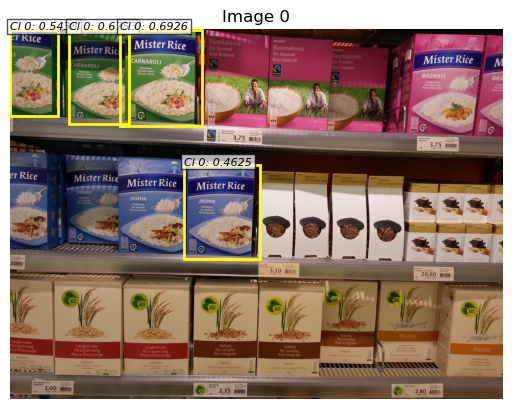

In [41]:
lcp.debug_for_test_vision(
    dataloader_train = dataloader_train,
    img_normalization = img_normalization,
    box_coder = box_coder,
    cfg = cfg,
    count = 2
)

### 這裡要跑 62 minutes for ALL

In [42]:
# for idx, layer_name in enumerate(layer_names):
#     if idx != 15:
#         continue
#     lcp.prune_layer(
#         layer_name   = layer_name,
#         discard_rate = 0.8,
#     )
#     break

#### Test for debug for vision after prune

In [43]:
# lcp.debug_for_test_vision(
#     dataloader_train = dataloader_train,
#     img_normalization = img_normalization,
#     box_coder = box_coder,
#     cfg = cfg,
#     count = 1
# )

In [44]:
import torch

def count_parameters(model):
    """
    計算模型的參數數量
    Returns:
      total_params: 包含所有參數
      trainable_params: 只包含 requires_grad=True 的參數
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

import io

def estimate_model_size(model):
    """
    將模型序列化到緩衝區，估算存檔大小（MB）
    """
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    size_mb = buffer.getbuffer().nbytes / (1024 ** 2)
    return size_mb



In [45]:
# # 使用範例
# print( "原始網路參數統計:\n" )
# model = lcp._net  
# total, trainable = count_parameters(model)
# print(f"總參數量: {total:,}")
# print(f"可訓練參數量: {trainable:,}")

# size_mb = estimate_model_size(model)
# print(f"模型存儲大小: {size_mb:.2f} MB")

# print( "剪枝網路參數統計:\n" )
# model = lcp._prune_net
# total, trainable = count_parameters(model)
# print(f"總參數量: {total:,}")
# print(f"可訓練參數量: {trainable:,}")

# size_mb = estimate_model_size(model)
# print(f"模型存儲大小: {size_mb:.2f} MB")

### Test for finetune

In [46]:
show_gpu_memory_usage()

🖥️  GPU 設備: NVIDIA GeForce GTX 1650 Ti
📊 記憶體使用情況:
   已分配: 0.08 GB
   已保留: 0.29 GB
   總容量: 4.00 GB
   使用率: 2.1%
   保留率: 7.2%
   [░░░░░░░░░░░░░░░░░░░░] 2%


In [47]:
from src.lcp.lcpfinetune import LCPFineTune
lcp_finetune = LCPFineTune(
    prune_net = lcp._prune_net,
    dataloader_train = dataloader_train,
    img_normalization = img_normalization,
    box_coder = box_coder,
    cfg       = cfg,
    optimizer=optimizer,
    parameters=parameters
)

In [48]:
show_gpu_memory_usage()

🖥️  GPU 設備: NVIDIA GeForce GTX 1650 Ti
📊 記憶體使用情況:
   已分配: 0.08 GB
   已保留: 0.29 GB
   總容量: 4.00 GB
   使用率: 2.1%
   保留率: 7.2%
   [░░░░░░░░░░░░░░░░░░░░] 2%


In [49]:
lcp_finetune._setup_logging()

In [50]:
cfg.defrost()

cfg.train.optim.max_iter = 100
cfg.train.do_training = True
cfg.output.print_iter = 10
cfg.eval.iter = 10
cfg.train.batch_size = 1

cfg.freeze()


In [51]:
from src.util.loss import LCPFinetuneCriterion

In [52]:

lcp_criterion = LCPFinetuneCriterion(
    original_criterion=criterion,  # 原始損失函數實例
    aux_net=lcp._aux_net,  # 包含 aux_loss 方法的實例
    auxiliary_weight=1.0  # 可以調整輔助損失權重
)

image to show size: (3264, 2448), res


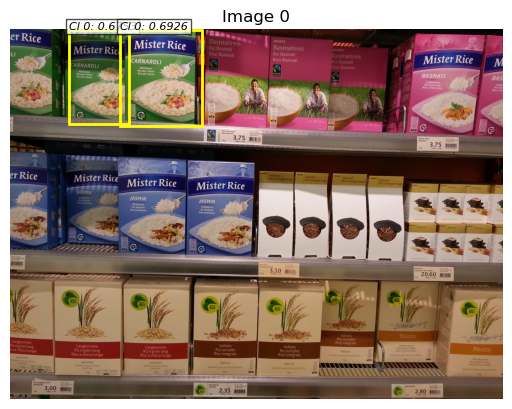

In [53]:
lcp.debug_for_test_vision(
    dataloader_train = dataloader_train,
    img_normalization = img_normalization,
    box_coder = box_coder,
    cfg = cfg,
    count = 1
)

In [54]:
def show_network_status( orig_net, prune_net ):
    print( "原始網路參數統計:\n" )
    model = orig_net
    total, trainable = count_parameters(model)
    print(f"總參數量: {total:,}")
    print(f"可訓練參數量: {trainable:,}")

    size_mb = estimate_model_size(model)
    print(f"模型存儲大小: {size_mb:.2f} MB")

    print( "剪枝網路參數統計:\n" )
    model = prune_net
    total, trainable = count_parameters(model)
    print(f"總參數量: {total:,}")
    print(f"可訓練參數量: {trainable:,}")

    size_mb = estimate_model_size(model)
    print(f"模型存儲大小: {size_mb:.2f} MB")

In [55]:
for idx, layer_name in enumerate(layer_names):
    print(f"剪枝前的網路統計: {idx} {layer_name}")

剪枝前的網路統計: 0 layer1.0.conv1
剪枝前的網路統計: 1 layer1.0.conv2
剪枝前的網路統計: 2 layer1.1.conv1
剪枝前的網路統計: 3 layer1.1.conv2
剪枝前的網路統計: 4 layer1.2.conv1
剪枝前的網路統計: 5 layer1.2.conv2
剪枝前的網路統計: 6 layer2.0.conv1
剪枝前的網路統計: 7 layer2.0.conv2
剪枝前的網路統計: 8 layer2.1.conv1
剪枝前的網路統計: 9 layer2.1.conv2
剪枝前的網路統計: 10 layer2.2.conv1
剪枝前的網路統計: 11 layer2.2.conv2
剪枝前的網路統計: 12 layer2.3.conv1
剪枝前的網路統計: 13 layer2.3.conv2
剪枝前的網路統計: 14 layer3.0.conv1
剪枝前的網路統計: 15 layer3.0.conv2
剪枝前的網路統計: 16 layer3.1.conv1
剪枝前的網路統計: 17 layer3.1.conv2
剪枝前的網路統計: 18 layer3.2.conv1
剪枝前的網路統計: 19 layer3.2.conv2
剪枝前的網路統計: 20 layer3.3.conv1
剪枝前的網路統計: 21 layer3.3.conv2
剪枝前的網路統計: 22 layer3.4.conv1
剪枝前的網路統計: 23 layer3.4.conv2
剪枝前的網路統計: 24 layer3.5.conv1
剪枝前的網路統計: 25 layer3.5.conv2


In [56]:
# for idx, layer_name in enumerate(layer_names):
#     if layer_name == 'layer3.0.conv1' or layer_name == 'layer3.1.conv1' or layer_name == 'layer3.2.conv1' or layer_name == 'layer3.3.conv1' or layer_name == 'layer3.4.conv1' or layer_name == 'layer3.5.conv1':
#         continue
#     cfg.defrost()
#     if idx > 13:
#         cfg.train.optim.max_iter = 50
#         lcp.prune_layer(
#             layer_name   = layer_name,
#             discard_rate = 0.5,
#         )
#     else:
#         cfg.train.optim.max_iter = 1
#         lcp.prune_layer(
#             layer_name   = layer_name,
#             discard_rate = 0.8,
#         )
#     cfg.freeze()
#     lcp_finetune.start_finetune(
#         criterion= lcp_criterion,  # 使用自定義損失函數
#     )
#     show_gpu_memory_usage()
#     print(f"剪枝後網路狀態 (第 {idx+1}, {layer_name} 層):")
#     show_network_status(lcp._net, lcp_finetune._prune_net)
#     lcp._prune_net = lcp_finetune._prune_net  # 更新剪枝網路
#     lcp.save_checkpoint_with_pruned_net(
#         log_path = './src/util/checkpoints-test',
#         optimizer = optimizer,
#         model_name = f"lcp_finetune_{idx+1}_{layer_name}",
#         i_iter = cfg.train.optim.max_iter
#     )
#     lcp.debug_for_test_vision(
#         dataloader_train = dataloader_train,
#         img_normalization = img_normalization,
#         box_coder = box_coder,
#         cfg = cfg,
#         count = 2
#     )
#     break

image to show size: (3264, 2448), res


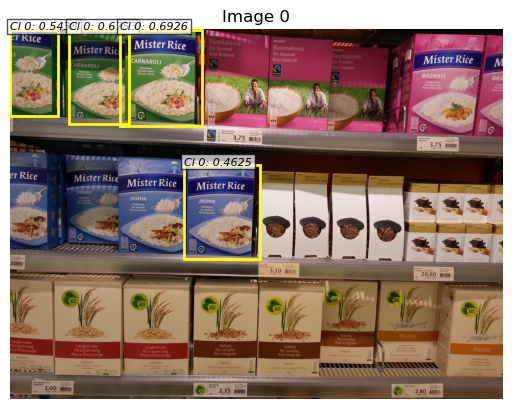

In [57]:
lcp.debug_for_test_vision(
    dataloader_train = dataloader_train,
    img_normalization = img_normalization,
    box_coder = box_coder,
    cfg = cfg,
    count = 2
)

In [58]:
# lcp_finetune.finetune_one_batch(
#     batch_data = data,
#     lcp_instance = lcp,
#     criterion = criterion
# )

In [59]:
# lcp_finetune.finetune_loop(
#     lcp_instance = lcp,
#     criterion = criterion,
#     dataloaders_eval = dataloaders_eval,
#     max_iters = 5,
#     print_interval=2
# )

In [60]:
show_network_status(lcp._net, lcp._prune_net)

原始網路參數統計:

總參數量: 10,169,478
可訓練參數量: 10,169,478
模型存儲大小: 39.05 MB
剪枝網路參數統計:

總參數量: 10,169,478
可訓練參數量: 10,169,478
模型存儲大小: 39.05 MB


In [68]:
print( lcp._pruner.resolve_layer_dependencies( "layer1.0.conv1"))

=== net_feature_maps 詳細層級資訊 ===
[LCP] 層級依賴分析完成 - layer1.0.conv1
      BatchNorm: net_feature_maps.layer1.0.bn1
      下游層級: 1 個
      跳躍連接: 0 個
{'target': 'layer1.0.conv1', 'batch_norm': 'net_feature_maps.layer1.0.bn1', 'downstream_layers': ['net_feature_maps.layer1.0.conv2'], 'downsample_layer': None, 'skip_connections': [], 'dependency_type': 'residual', 'pruning_strategy': 'sequential_pruning', 'needs_input_fix': True}


{'layer': 'net_feature_maps.layer1.0.conv1',
 'original_channel_num': 64,
 'num_of_keep_channel': 13,
 'keep_index': [0, 1, 4, 13, 14, 24, 29, 44, 53, 54, 60, 62, 63]}

In [61]:
lcp._prune_net = lcp._net

In [62]:
all_layers = lcp._prune_db.get_all_layers()
pruned_layers = [layer for layer in all_layers if layer.startswith('layer')]
        
print( pruned_layers )

['layer1.0.conv1']


In [63]:
pruned_net_checkpoint = lcp.load_checkpoint_with_pruned_net(
    checkpoint_file_path = './src/util/checkpoints-test/checkpoint_lcp_finetune_1_layer1.0.conv1.pth'
)

Loading checkpoint from ./src/util/checkpoints-test/checkpoint_lcp_finetune_1_layer1.0.conv1.pth
Restoring pruned parameters to original dimensions...
Found 4 total layers in database
Filtered to 1 layers starting with 'layer'
Processing parameter: net_feature_maps.conv1.weight, tensor shape: torch.Size([64, 3, 7, 7])
layer_name : net_feature_maps.conv1 / pruned_layers : ['layer1.0.conv1'] / if layer_name in pruned_layers: False
Processing parameter: net_feature_maps.bn1.weight, tensor shape: torch.Size([64])
layer_name : net_feature_maps.bn1 / pruned_layers : ['layer1.0.conv1'] / if layer_name in pruned_layers: False
Processing parameter: net_feature_maps.bn1.bias, tensor shape: torch.Size([64])
layer_name : net_feature_maps.bn1 / pruned_layers : ['layer1.0.conv1'] / if layer_name in pruned_layers: False
Processing parameter: net_feature_maps.bn1.running_mean, tensor shape: torch.Size([64])
layer_name : net_feature_maps.bn1 / pruned_layers : ['layer1.0.conv1'] / if layer_name in prune

Could not load checkpoint for some reason: Error(s) in loading state_dict for Os2dModel:
	size mismatch for net_feature_maps.layer1.0.conv1.weight: copying a param with shape torch.Size([13, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 1, 1]).
	size mismatch for net_feature_maps.layer1.0.bn1.weight: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net_feature_maps.layer1.0.bn1.bias: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net_feature_maps.layer1.0.bn1.running_mean: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net_feature_maps.layer1.0.bn1.running_var: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net_feature_maps.layer1.0.conv2

Restore state : {'net_feature_maps.conv1.weight': tensor([[[[-1.4126e-01,  1.1013e+00,  1.2615e+00,  ..., -4.4497e+00,
           -4.1199e+00,  8.3280e-01],
          [ 2.1377e-02,  1.6859e+00,  6.7940e+00,  ..., -5.4301e-01,
           -7.5182e+00, -4.5825e+00],
          [-1.9315e+00, -5.0987e+00,  4.6583e+00,  ...,  1.2553e+01,
           -5.6389e+00, -1.0135e+01],
          ...,
          [ 1.1801e+00, -6.3240e+00, -1.5983e+01,  ...,  7.6235e+00,
            8.6525e+00,  1.7081e+00],
          [ 3.6888e+00,  2.6477e+00, -6.7074e+00,  ...,  4.5344e-02,
            3.7864e+00,  4.0264e+00],
          [ 1.0775e+00,  1.9416e+00, -1.1638e+00,  ..., -3.5165e+00,
            4.5388e-01,  1.5703e+00]],

         [[ 3.3205e-01,  1.0606e+00,  2.0424e+00,  ..., -5.2997e+00,
           -7.0292e+00, -1.5187e+00],
          [-4.3511e-01,  1.3762e+00,  8.4476e+00,  ...,  7.5782e-01,
           -1.0014e+01, -6.9674e+00],
          [-4.2203e+00, -8.6218e+00,  3.4561e+00,  ...,  1.8806e+01,
        

RuntimeError: Error(s) in loading state_dict for Os2dModel:
	size mismatch for net_feature_maps.layer1.0.conv1.weight: copying a param with shape torch.Size([13, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 1, 1]).
	size mismatch for net_feature_maps.layer1.0.bn1.weight: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net_feature_maps.layer1.0.bn1.bias: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net_feature_maps.layer1.0.bn1.running_mean: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net_feature_maps.layer1.0.bn1.running_var: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net_feature_maps.layer1.0.conv2.weight: copying a param with shape torch.Size([64, 13, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for net_label_features.net_class_features.layer1.0.conv1.weight: copying a param with shape torch.Size([13, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 1, 1]).
	size mismatch for net_label_features.net_class_features.layer1.0.bn1.weight: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net_label_features.net_class_features.layer1.0.bn1.bias: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net_label_features.net_class_features.layer1.0.bn1.running_mean: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net_label_features.net_class_features.layer1.0.bn1.running_var: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net_label_features.net_class_features.layer1.0.conv2.weight: copying a param with shape torch.Size([64, 13, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).

In [ ]:
print( lcp._prune_net)

In [ ]:
show_network_status(lcp._net, lcp._prune_net)

In [ ]:
# for i in range(250):
#     print(50 * '=' + f" {i+1} / 250 開始全局微調" + 50 * '=')
#     lcp_finetune.start_finetune(
#         criterion= lcp_criterion,  # 使用自定義損失函數
#     )
#     show_gpu_memory_usage()
#     show_network_status(lcp._net, lcp_finetune._prune_net)
#     lcp._prune_net = lcp_finetune._prune_net  # 更新剪枝網路
#     lcp.debug_for_test_vision(
#         dataloader_train = dataloader_train,
#         img_normalization = img_normalization,
#         box_coder = box_coder,
#         cfg = cfg,
#         count = 1
#     )